In [5]:
# FILENAMES real recording in sparcs
import numpy as np

names = [
    'CW50_0_0',
    'CW50_0_5',
    'CW50_0_10',
    'CW50_0_15',
    'CW50_30_0',
    'CW50_30_5',
    'CW50_30_10',
    'CW50_30_15',
    'ACW50_0_0',
    'ACW50_0_5',
    'ACW50_0_10',
    'ACW50_0_15',
    'ACW50_30_0',
    'ACW50_30_5',
    'ACW50_30_10',
    'ACW50_30_15',

    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
    # 'CW50_0_0',
]

#NOTES: 
# -CW50_0_0 is only one lap

CAM_Z = 0.195
CAM_ROLL = np.deg2rad(-2)
CAM_PITCH = np.deg2rad(24)

VICON_STATIC_FRAMES_DELAY = 5
YAW_ERROR = np.deg2rad(2.5)



In [6]:
import numpy as np
def compensate_vicon_delay(imgs, locs):
    """
    Compensate for the delay between the Vicon and the images.
    """
    locs = locs[:-VICON_STATIC_FRAMES_DELAY]
    imgs = imgs[VICON_STATIC_FRAMES_DELAY:]
    assert len(imgs) == len(locs)
    
    xs, ys, yaws = locs[:,0], locs[:,1], locs[:,2]
    yaws = yaws - YAW_ERROR
    locs = np.stack([xs, ys, yaws], axis=1)

    return imgs, locs

In [7]:
# generating simulator version of real video
from unittest.mock import CallableMixin
import numpy as np
import rospy 
import rospkg 
from gazebo_msgs.msg import ModelState 
from gazebo_msgs.srv import SetModelState
from cv_bridge import CvBridge
from sensor_msgs.msg import Image, Range
import os
from time import sleep
import cv2 as cv
from Simulator.src.helper_functions import *

path = np.load('sparcs/sparcs_path.npy').T
lane_int = np.load('sparcs/sparcs_path_int.npy').T
lane_ext = np.load('sparcs/sparcs_path_ext.npy').T


frame = None
bridge = CvBridge()

#create rosservice
rospy.init_node('gazebo_move')
#create subscriber for automobile/image_raw
def camera_callback(data) -> None:
    """Receive and store camera frame
    :acts on: self.frame
    """        
    global frame, bridge
    frame = bridge.imgmsg_to_cv2(data, "bgr8")

camera_sub = rospy.Subscriber('/automobile/image_raw', Image, camera_callback)

cv.namedWindow('frame', cv.WINDOW_NORMAL)
cv.resizeWindow('frame', 640, 480)
cv.namedWindow('real', cv.WINDOW_NORMAL)
cv.resizeWindow('real', 640, 480)

rospy.wait_for_service('/gazebo/set_model_state')

state_msg = ModelState()
state_msg.model_name = 'automobile'
state_msg.pose.position.x = 0
state_msg.pose.position.y = 0
state_msg.pose.position.z = 0.032939
state_msg.pose.orientation.x = 0
state_msg.pose.orientation.y = 0
state_msg.pose.orientation.z = 0
state_msg.pose.orientation.w = 0

please_break = False
for name in names:
    print(name)
    log = np.load('saved_tests/'+name+'.npz')
    imgs, locs = log['imgs'],log['locs']
    imgs, locs = compensate_vicon_delay(imgs, locs)
    #get ony the first lap
    # imgs = imgs[:1473//2] #//2
    # locs = locs[:1473//2] #

    cv.resizeWindow('frame', 640, 480)
    cv.resizeWindow('real', 640, 480)

    sim_imgs = np.zeros_like(imgs)


    for i,(img,l) in enumerate(zip(imgs,locs)):
        x = l[0] + 2.5
        y = l[1] + 2.5 - 15.0
        yaw = l[2]
        x,y,yaw = rear2com(x,y,yaw) #convert from rear axle to center of mass

        qx = 0
        qy = 0
        qz = np.sin(yaw/2)
        qw = np.cos(yaw/2)

        state_msg.pose.position.x = x
        state_msg.pose.position.y = y
        state_msg.pose.orientation.z = qz
        state_msg.pose.orientation.w = qw

        set_state = rospy.ServiceProxy('/gazebo/set_model_state', SetModelState)
        resp = set_state(state_msg)
        sleep(0.008)
        #convert frame to gray
        tmp_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        tmp_frame = cv.resize(tmp_frame, (320,240), interpolation = cv.INTER_AREA)
        sim_imgs[i] = tmp_frame

        sim_img = cv.resize(frame, (320,240), interpolation = cv.INTER_AREA)

        x,y,yaw = l
        img, _ = project_onto_frame2(img,path, x,y,yaw, color=(0,0,255), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        img, _ = project_onto_frame2(img,lane_int, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        img, _ = project_onto_frame2(img,lane_ext, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        sim_img, _ = project_onto_frame2(sim_img,path, x,y,yaw, color=(0,0,255), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        sim_img, _ = project_onto_frame2(sim_img,lane_int, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        sim_img, _ = project_onto_frame2(sim_img,lane_ext, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)



        cv.imshow('frame', sim_img)
        cv.imshow('real', img)
        #check if its ESC
        please_break = cv.waitKey(1) == 27
        
        if please_break:
            break
        # os.system('rosservice call /gazebo/set_model_state "{model_state: { model_name: '+"'automobile'"+', pose: { position: { x: '+str(x)+', y: '+str(y)+', z: 0.032939 }, orientation: { x: '+str(qx)+', y: '+str(qy)+', z: '+str(qz)+', w: '+str(qw)+' } }, twist: { linear: { x: 0.0, y: 0.0, z: 0.0 }, angular: { x: 0.0, y: 0.0, z: 0.0 } }, reference_frame: '+"'world'"+' } }"')

    if please_break:
        break
    else:
        np.savez_compressed('saved_tests/'+name + '_SIM.npz', imgs=sim_imgs, locs=locs)


cv.destroyAllWindows()


CW50_0_0
CW50_0_5
CW50_0_10
CW50_0_15
CW50_30_0
CW50_30_5
CW50_30_10
CW50_30_15
ACW50_0_0
ACW50_0_5
ACW50_0_10
ACW50_0_15
ACW50_30_0
ACW50_30_5
ACW50_30_10
ACW50_30_15


CW50_0_0
frames: 707, locs: 707
frame dim (240, 320), locs dim (3,)
we are too far from the path, min_dist: 0.47250000072905207


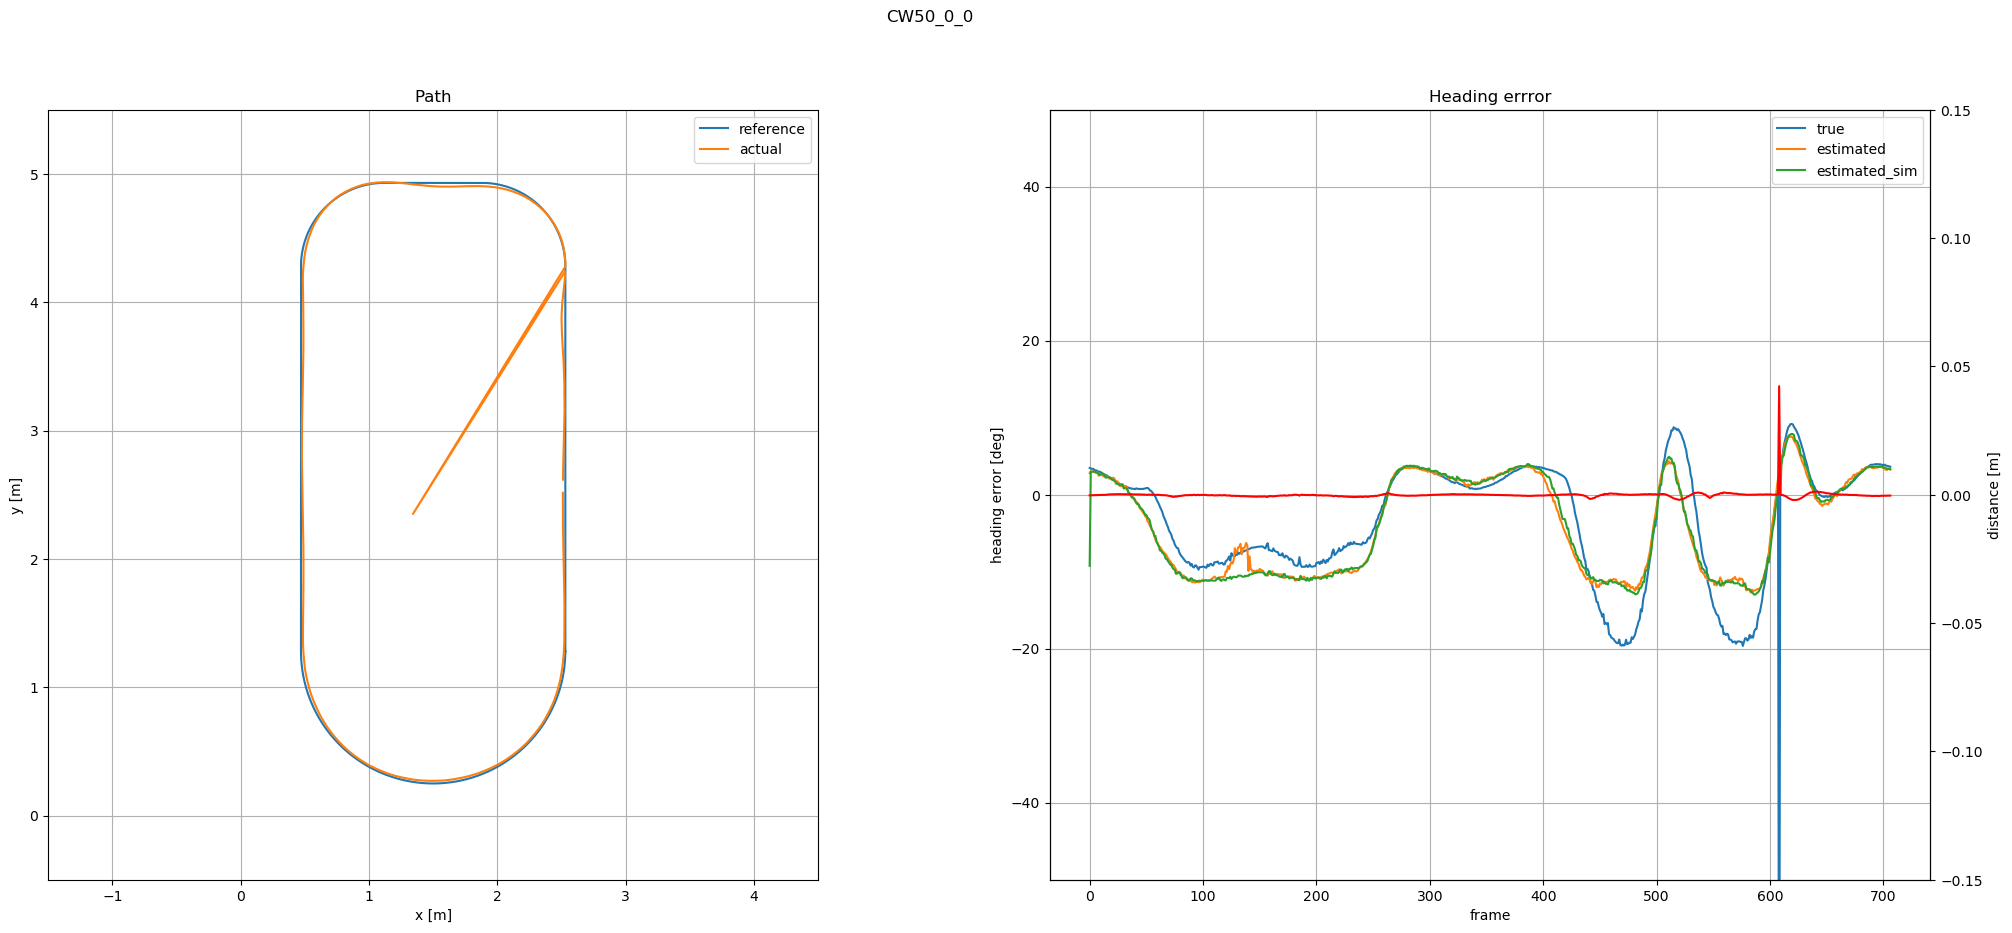

 
CW50_0_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


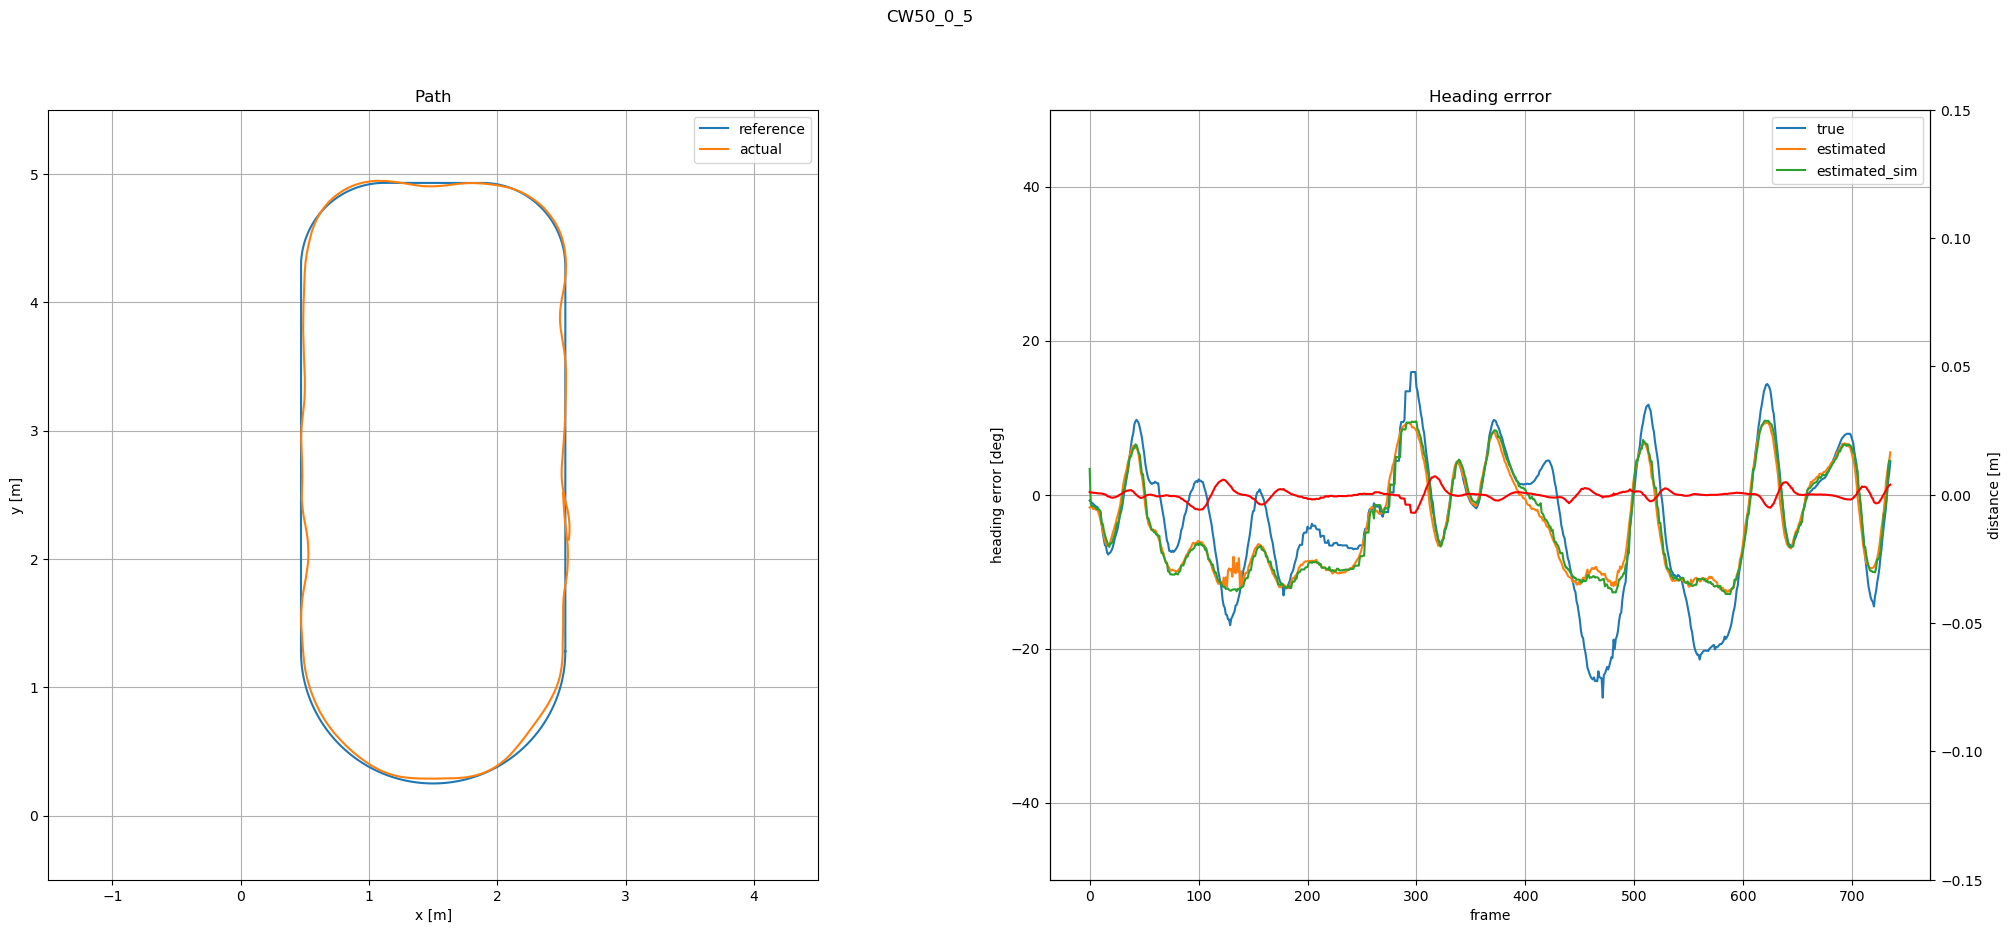

 
CW50_0_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


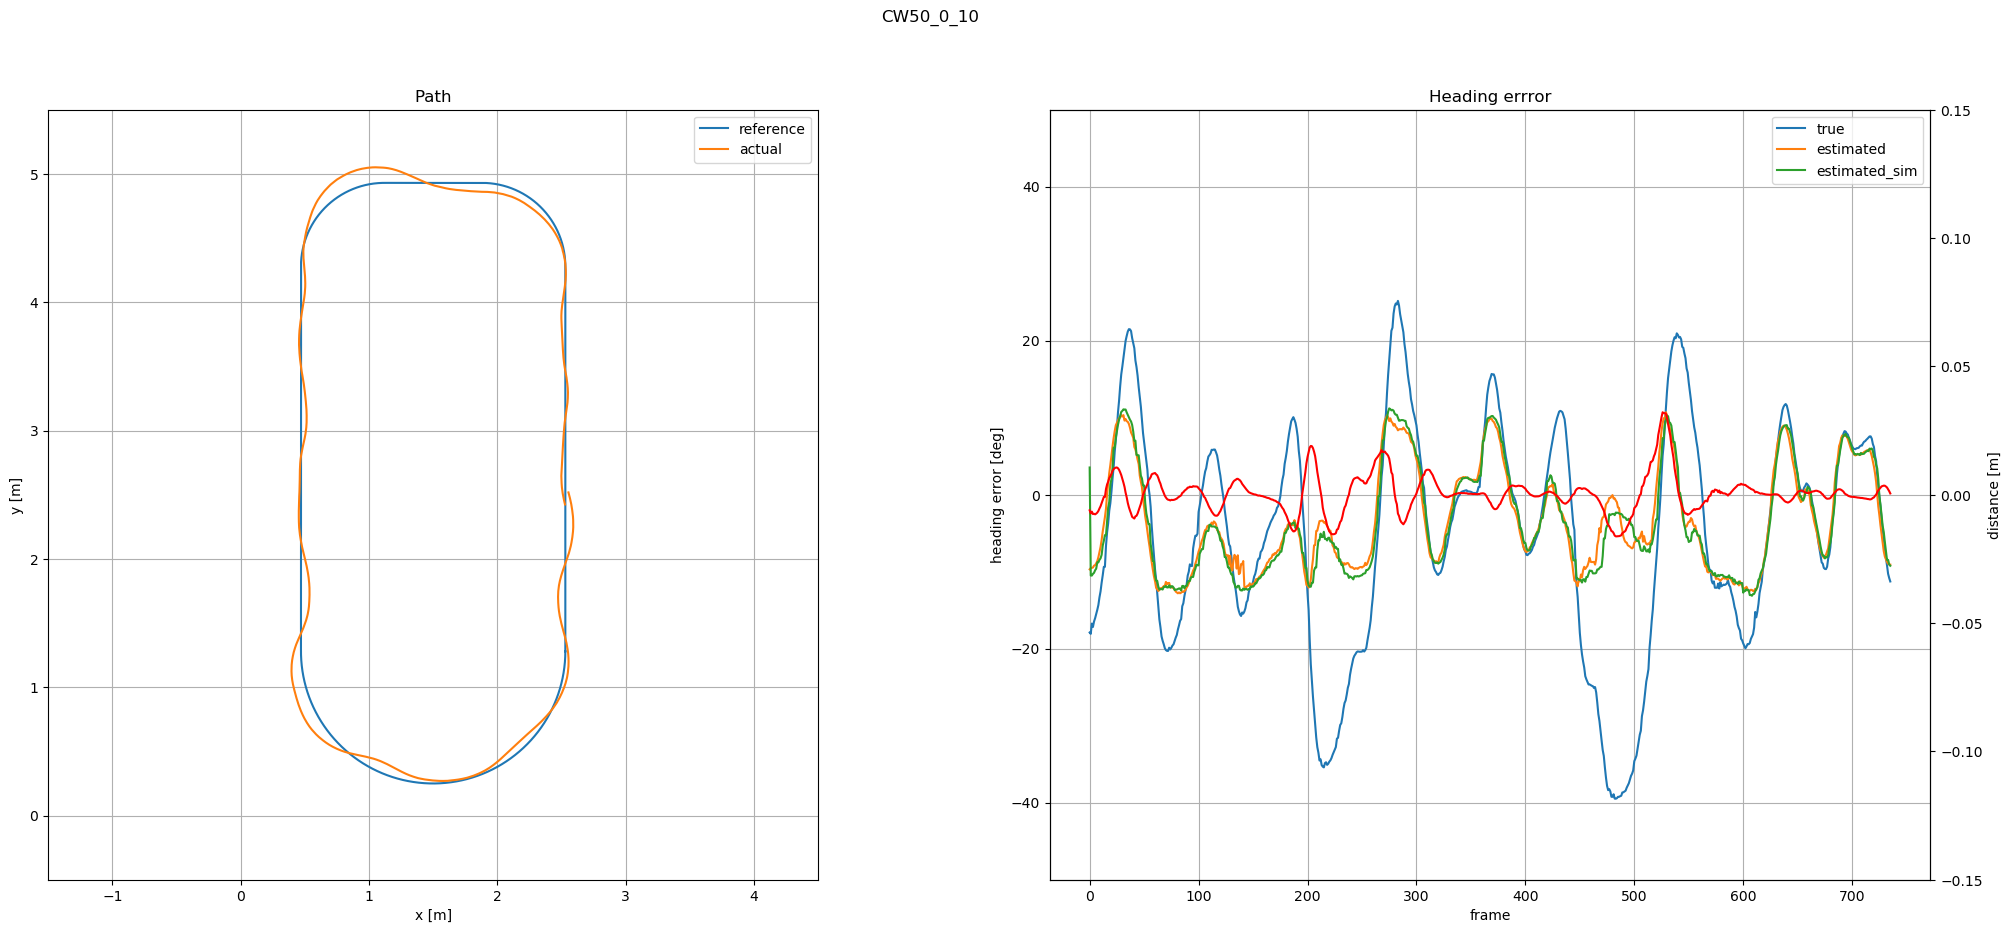

 
CW50_0_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


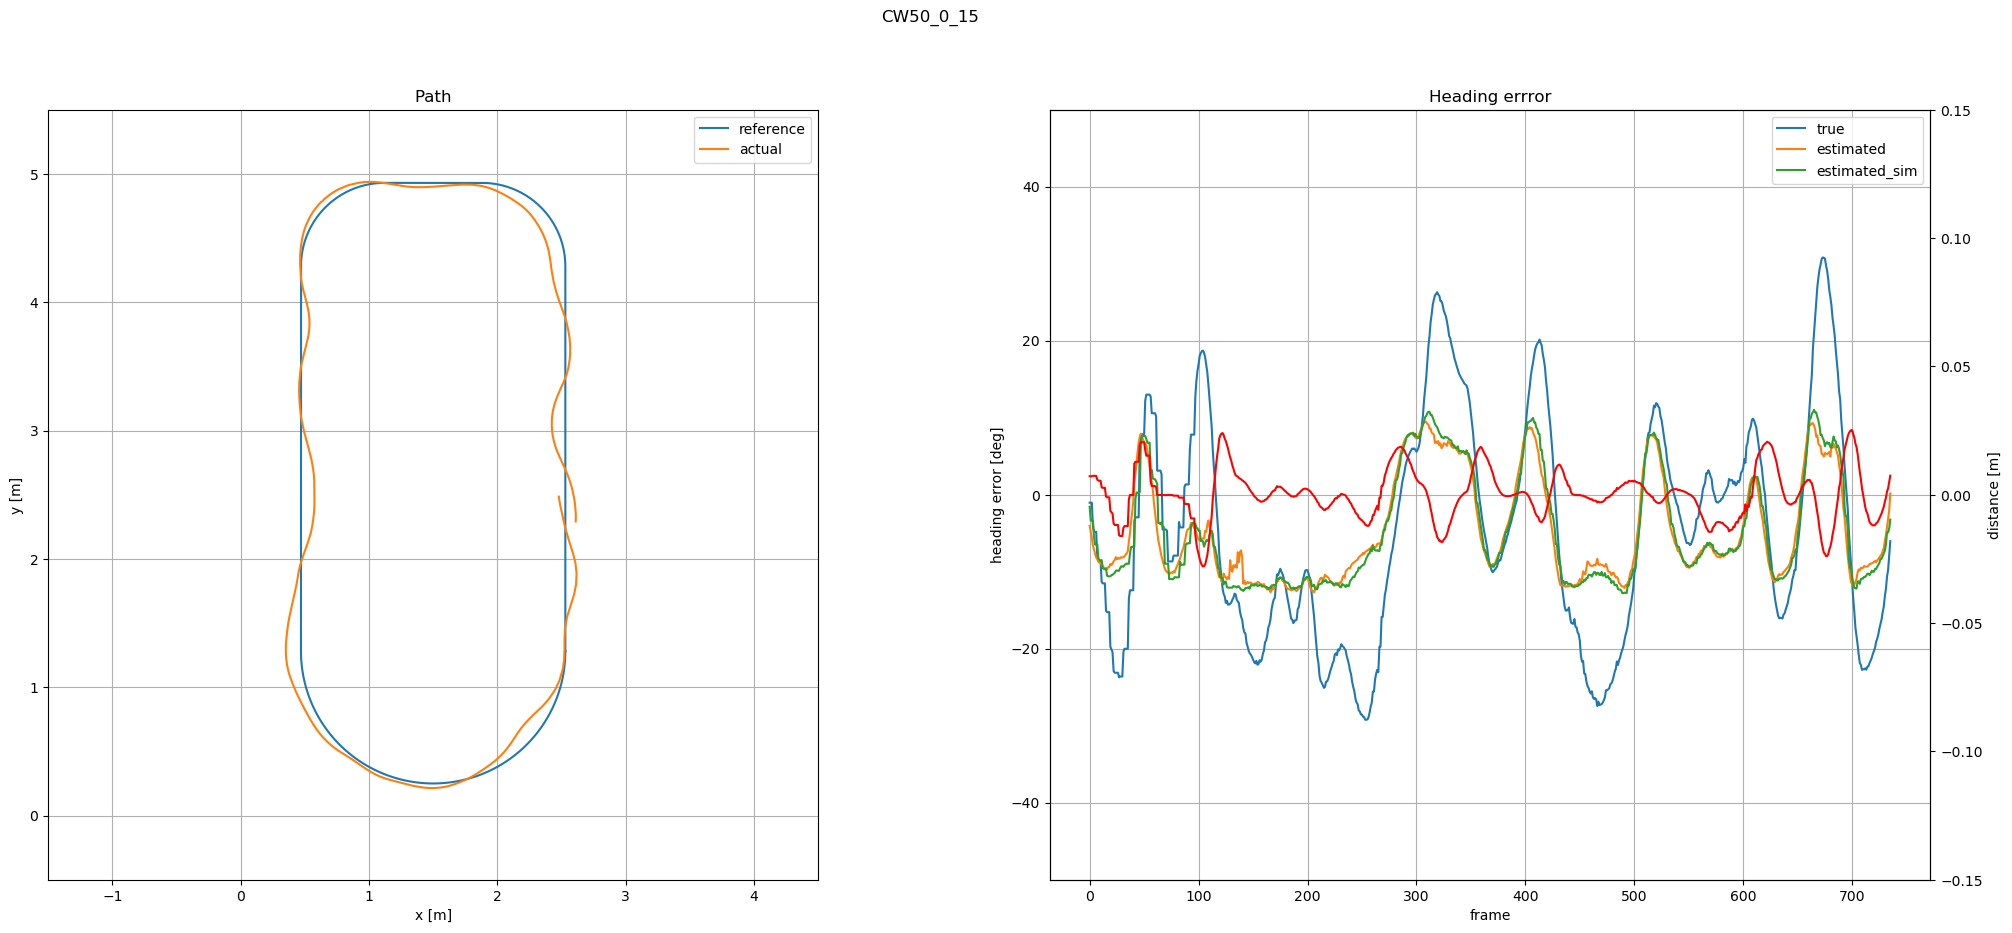

 
CW50_30_0
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


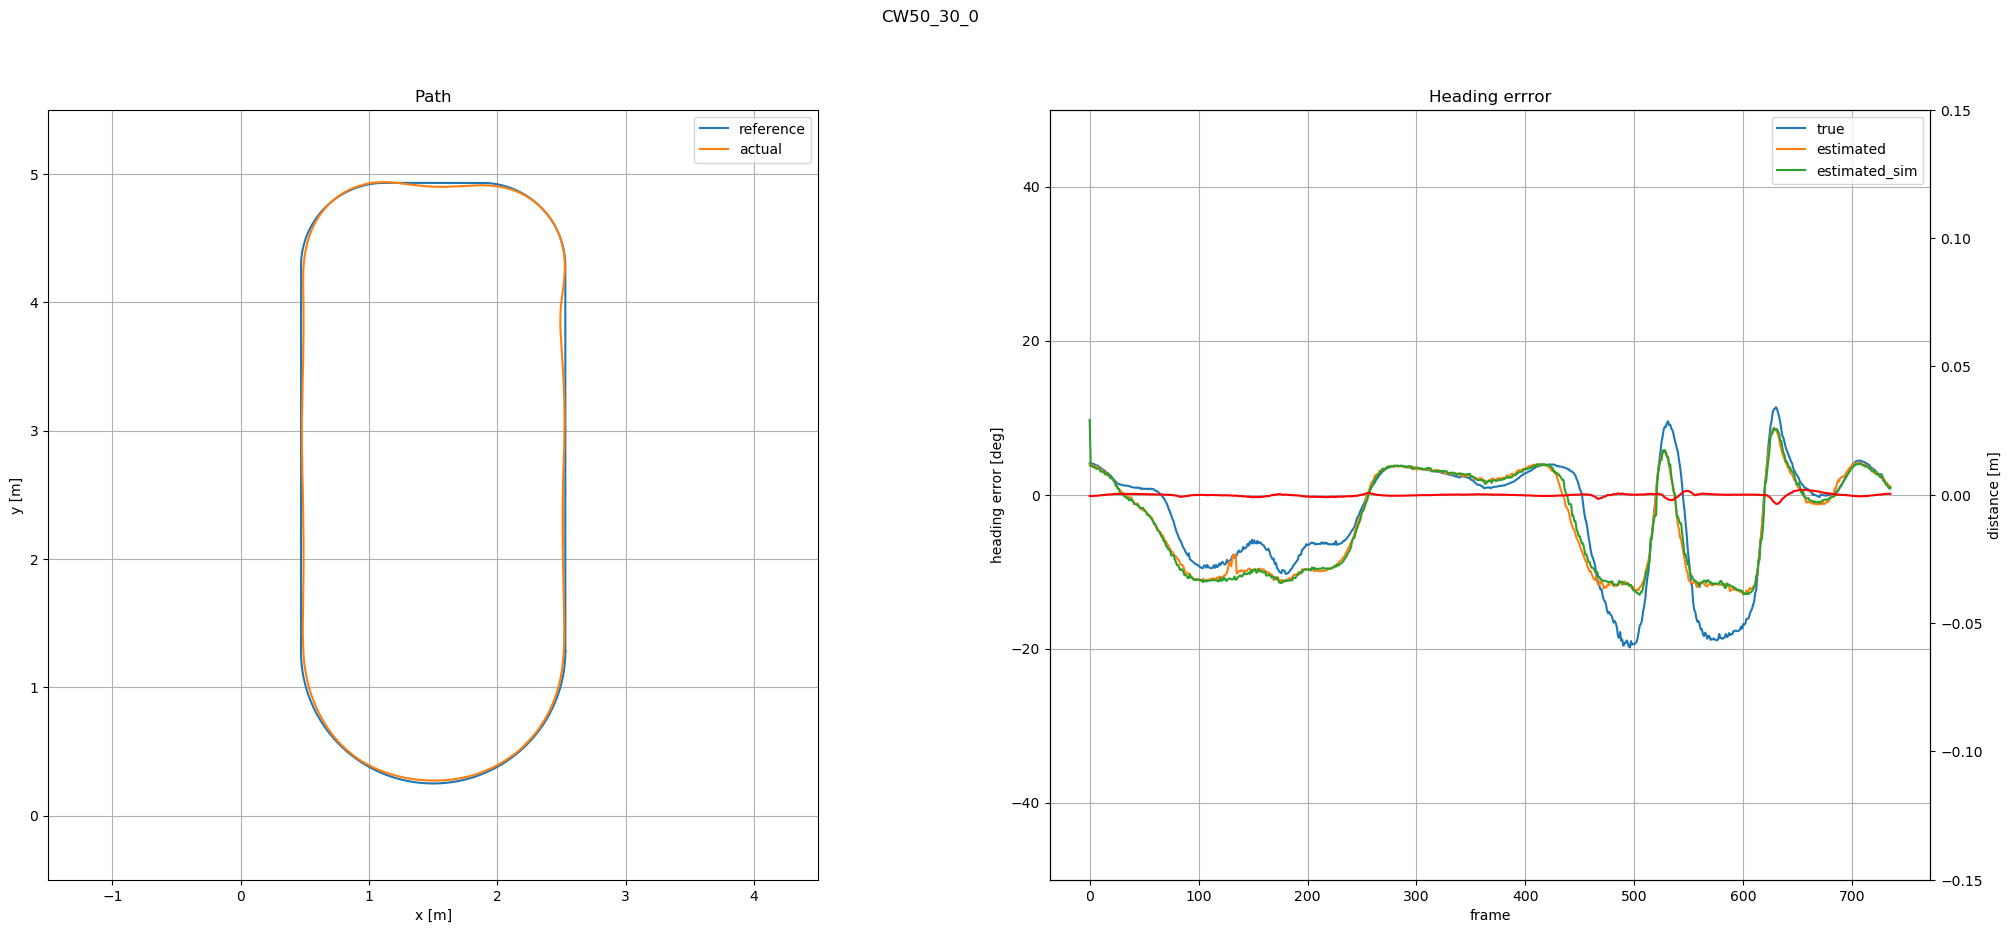

 
CW50_30_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


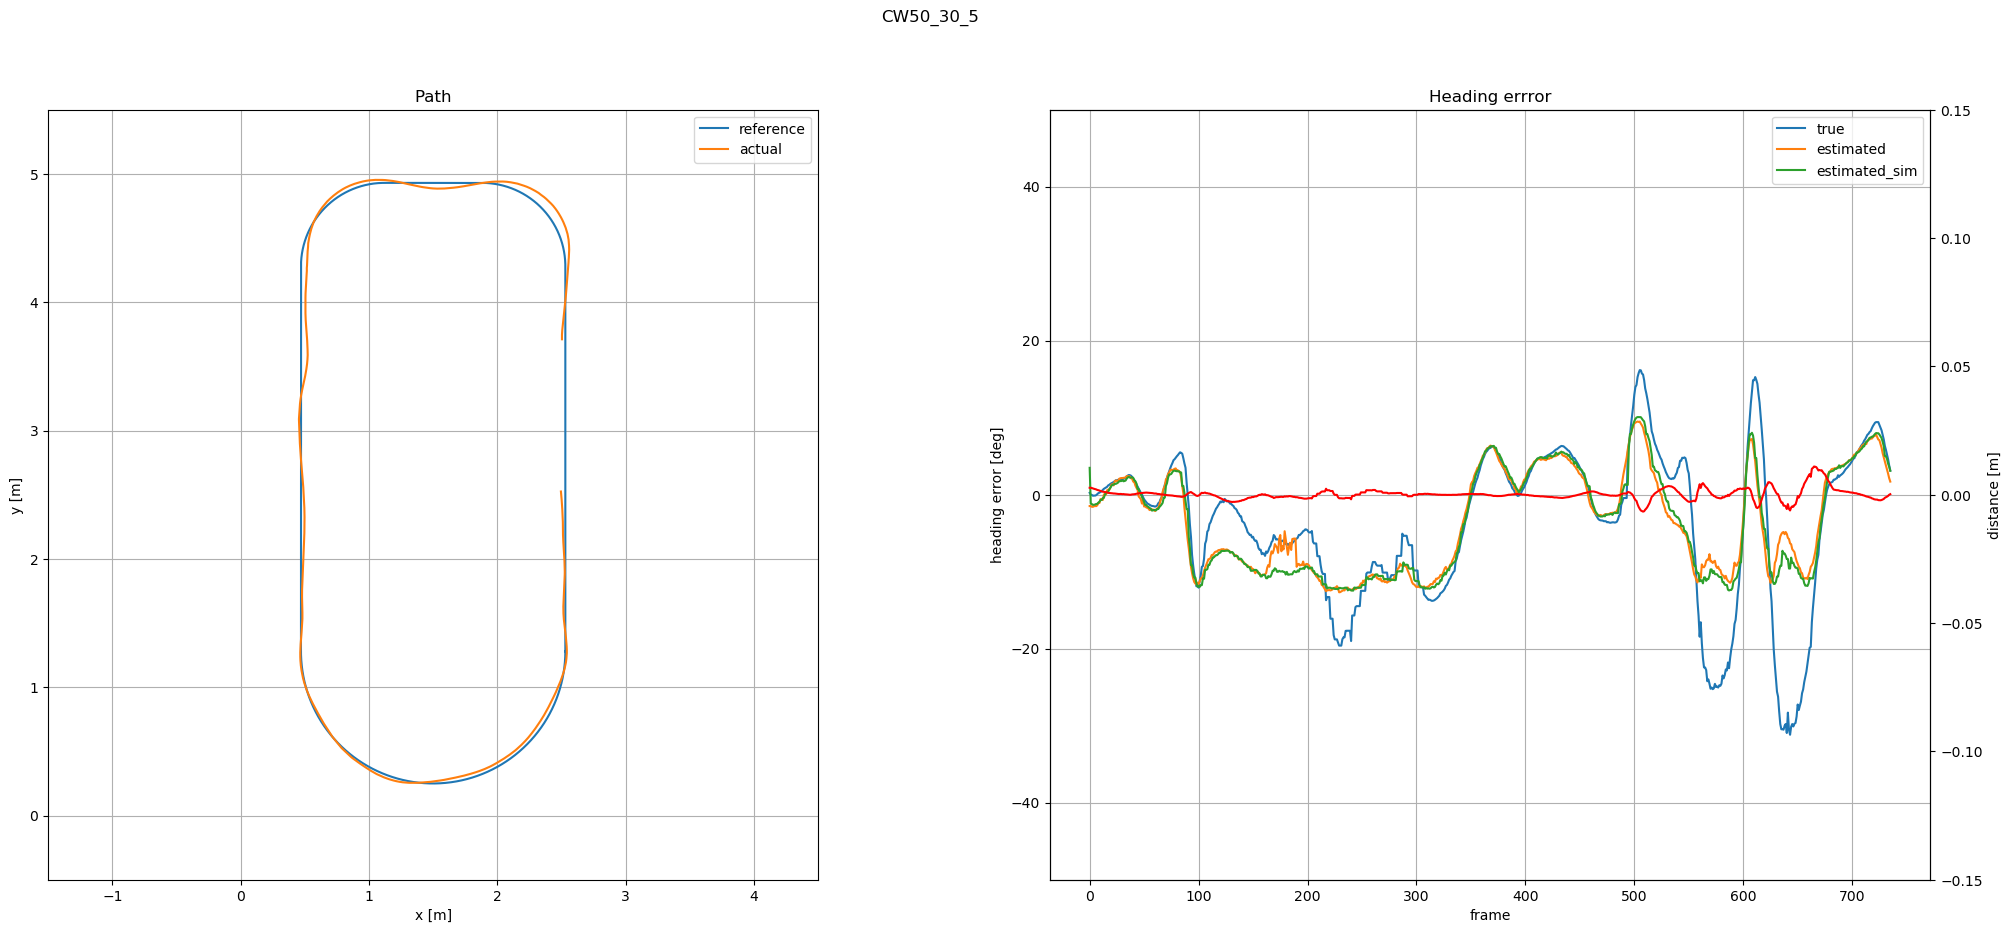

 
CW50_30_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


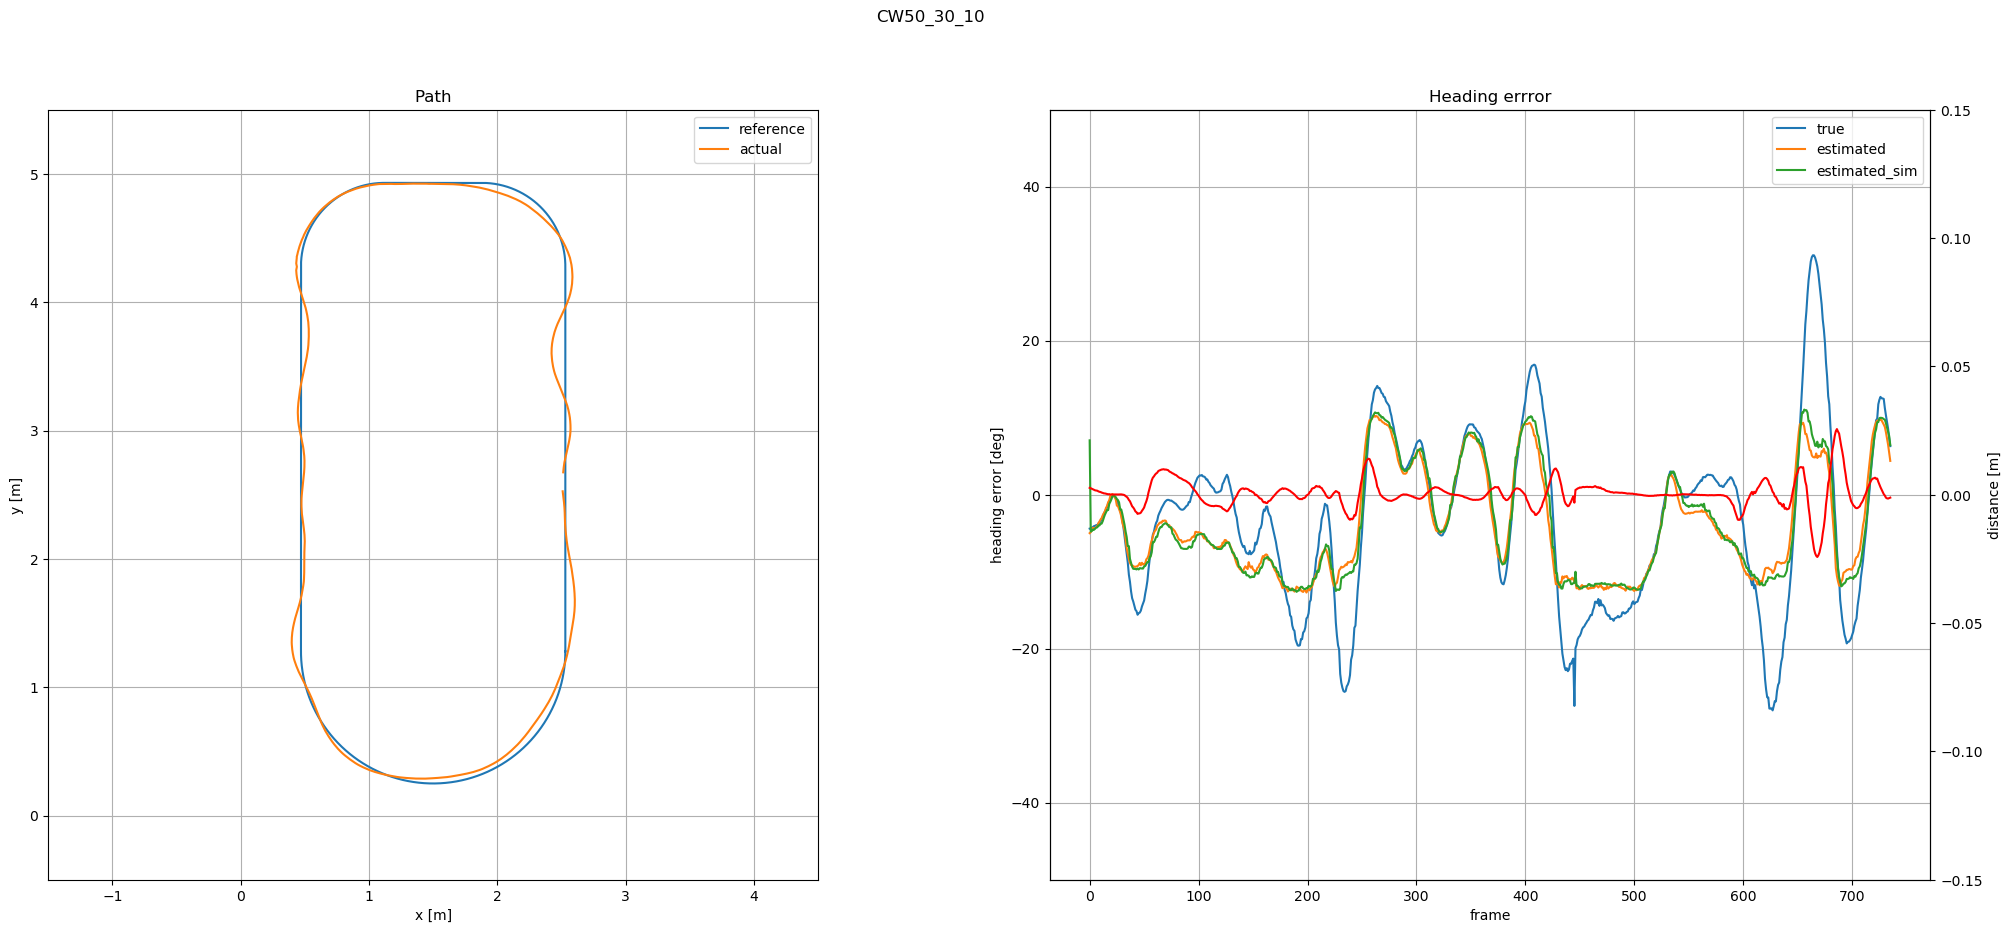

 
CW50_30_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


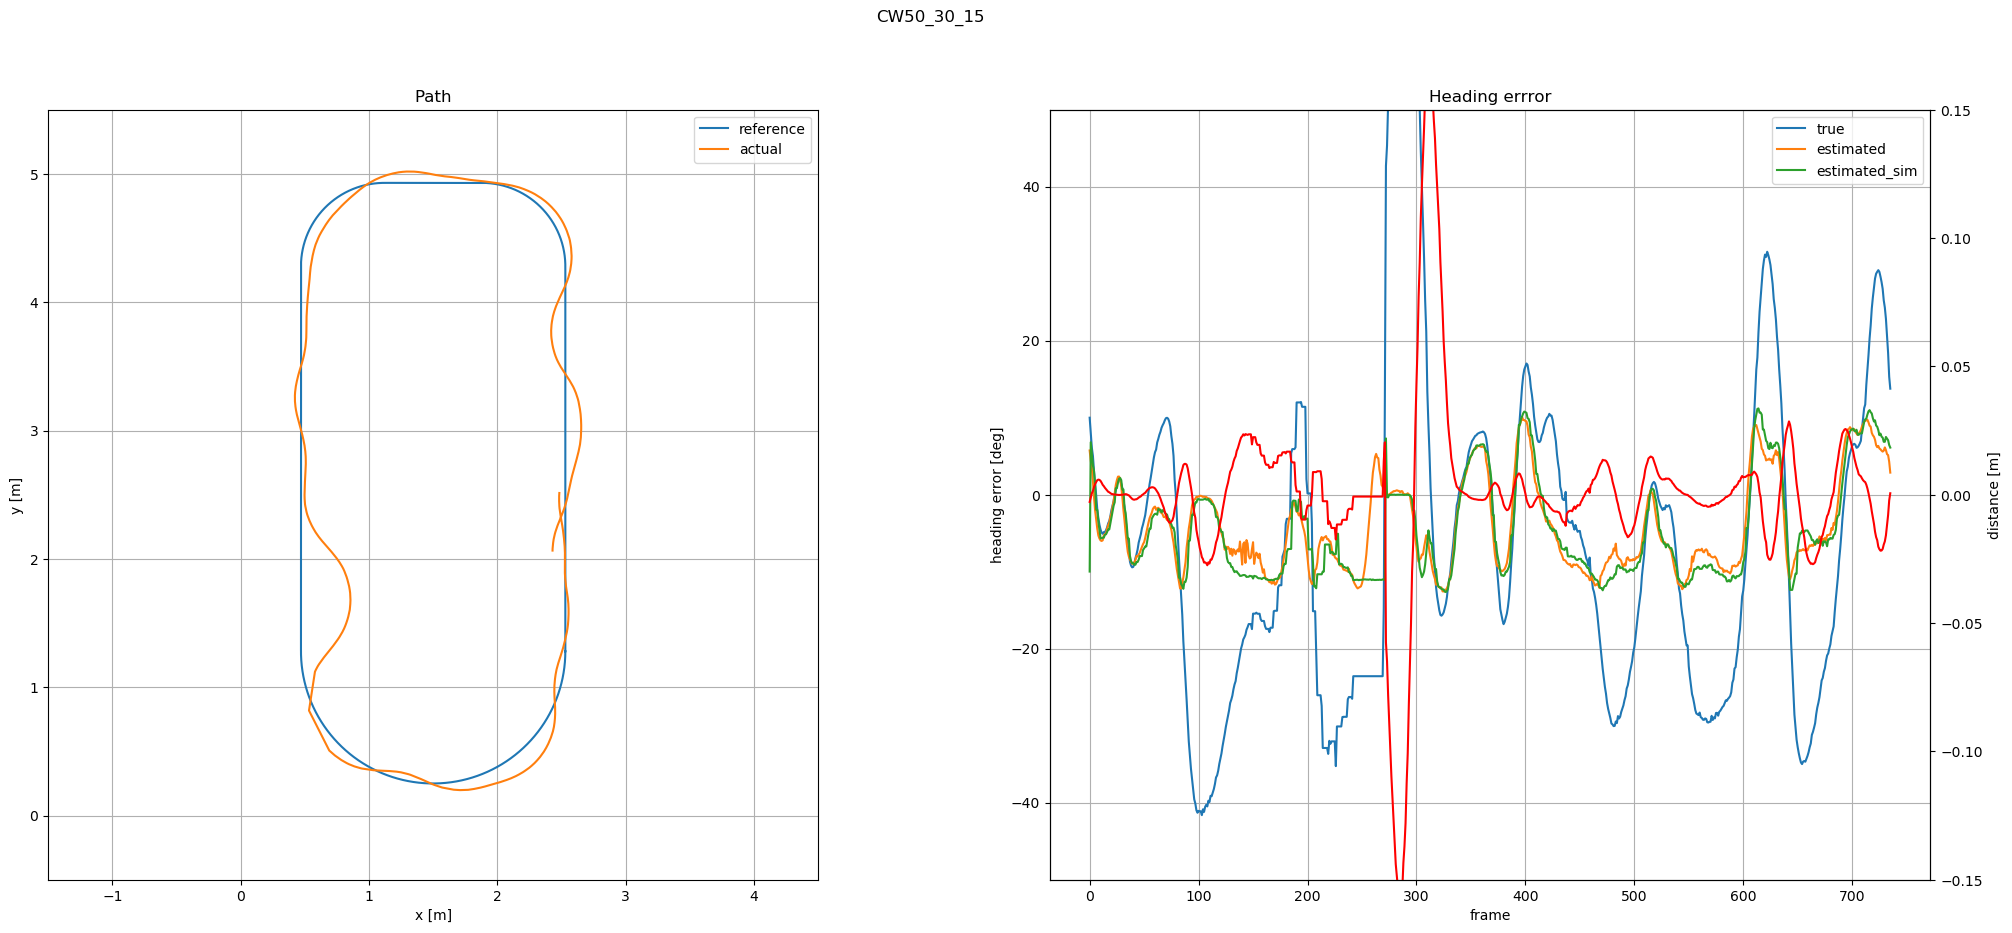

 
ACW50_0_0
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


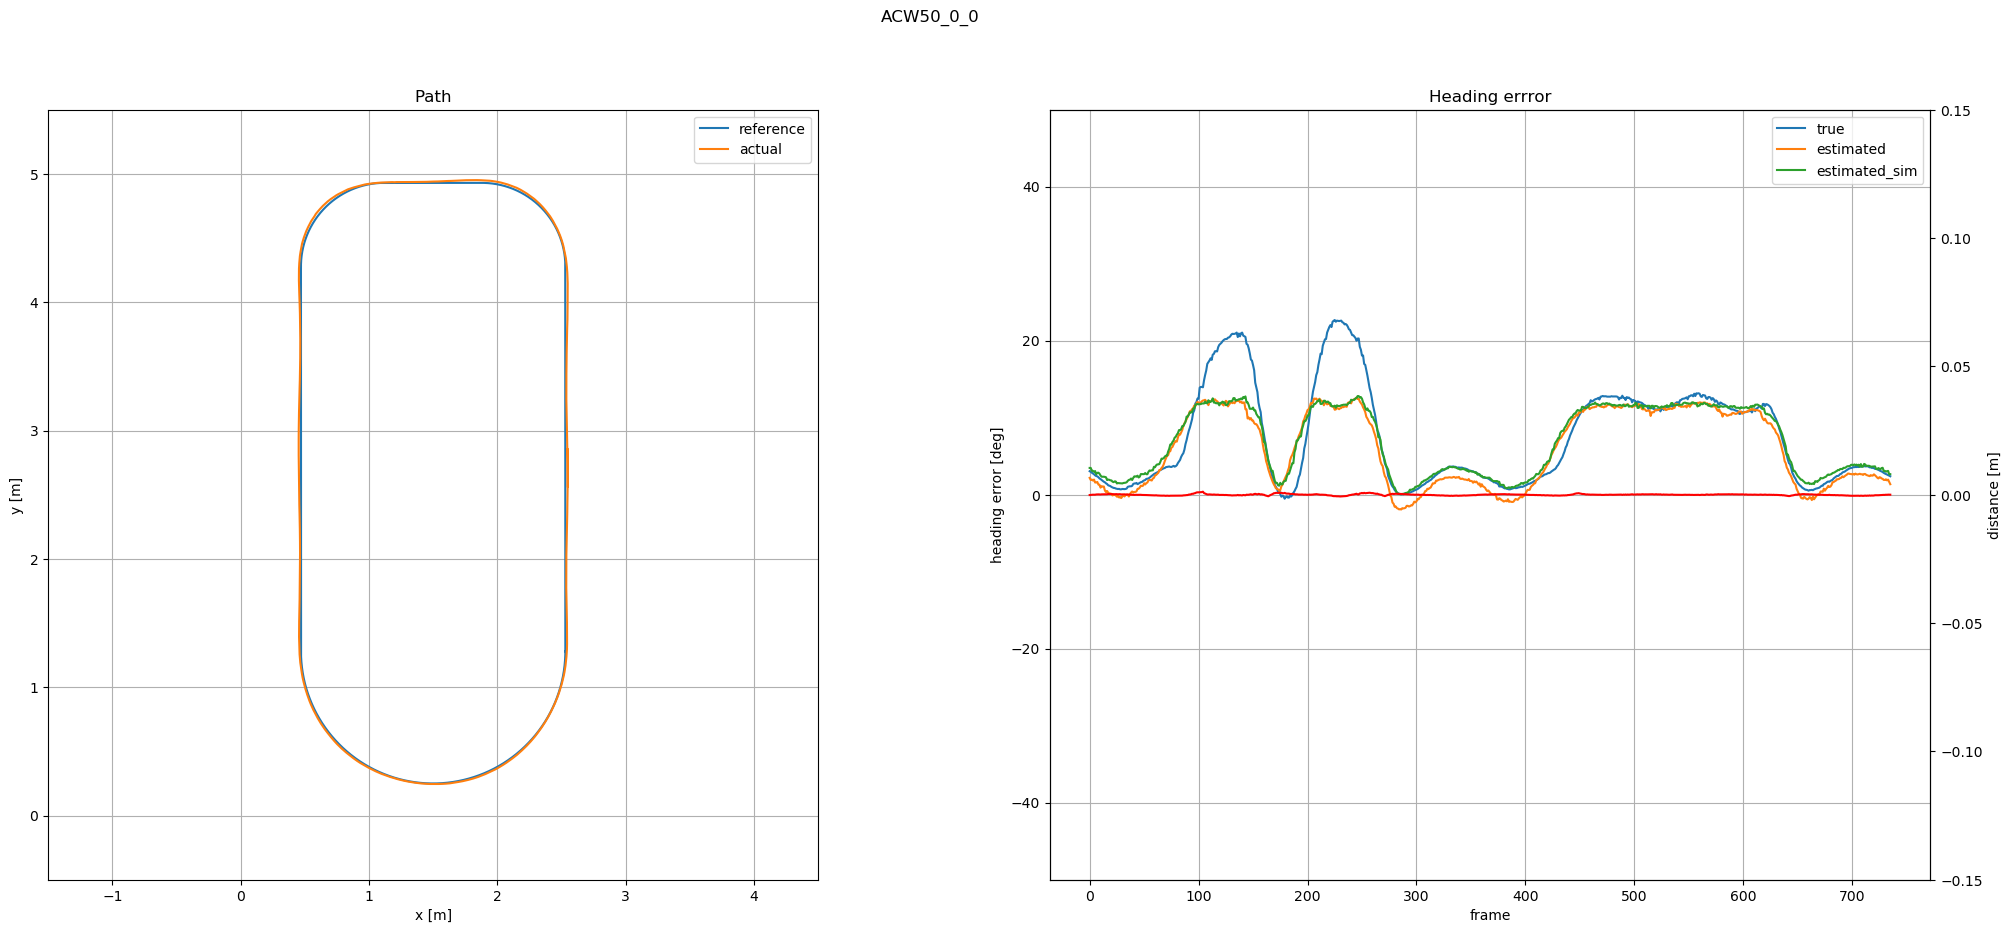

 
ACW50_0_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


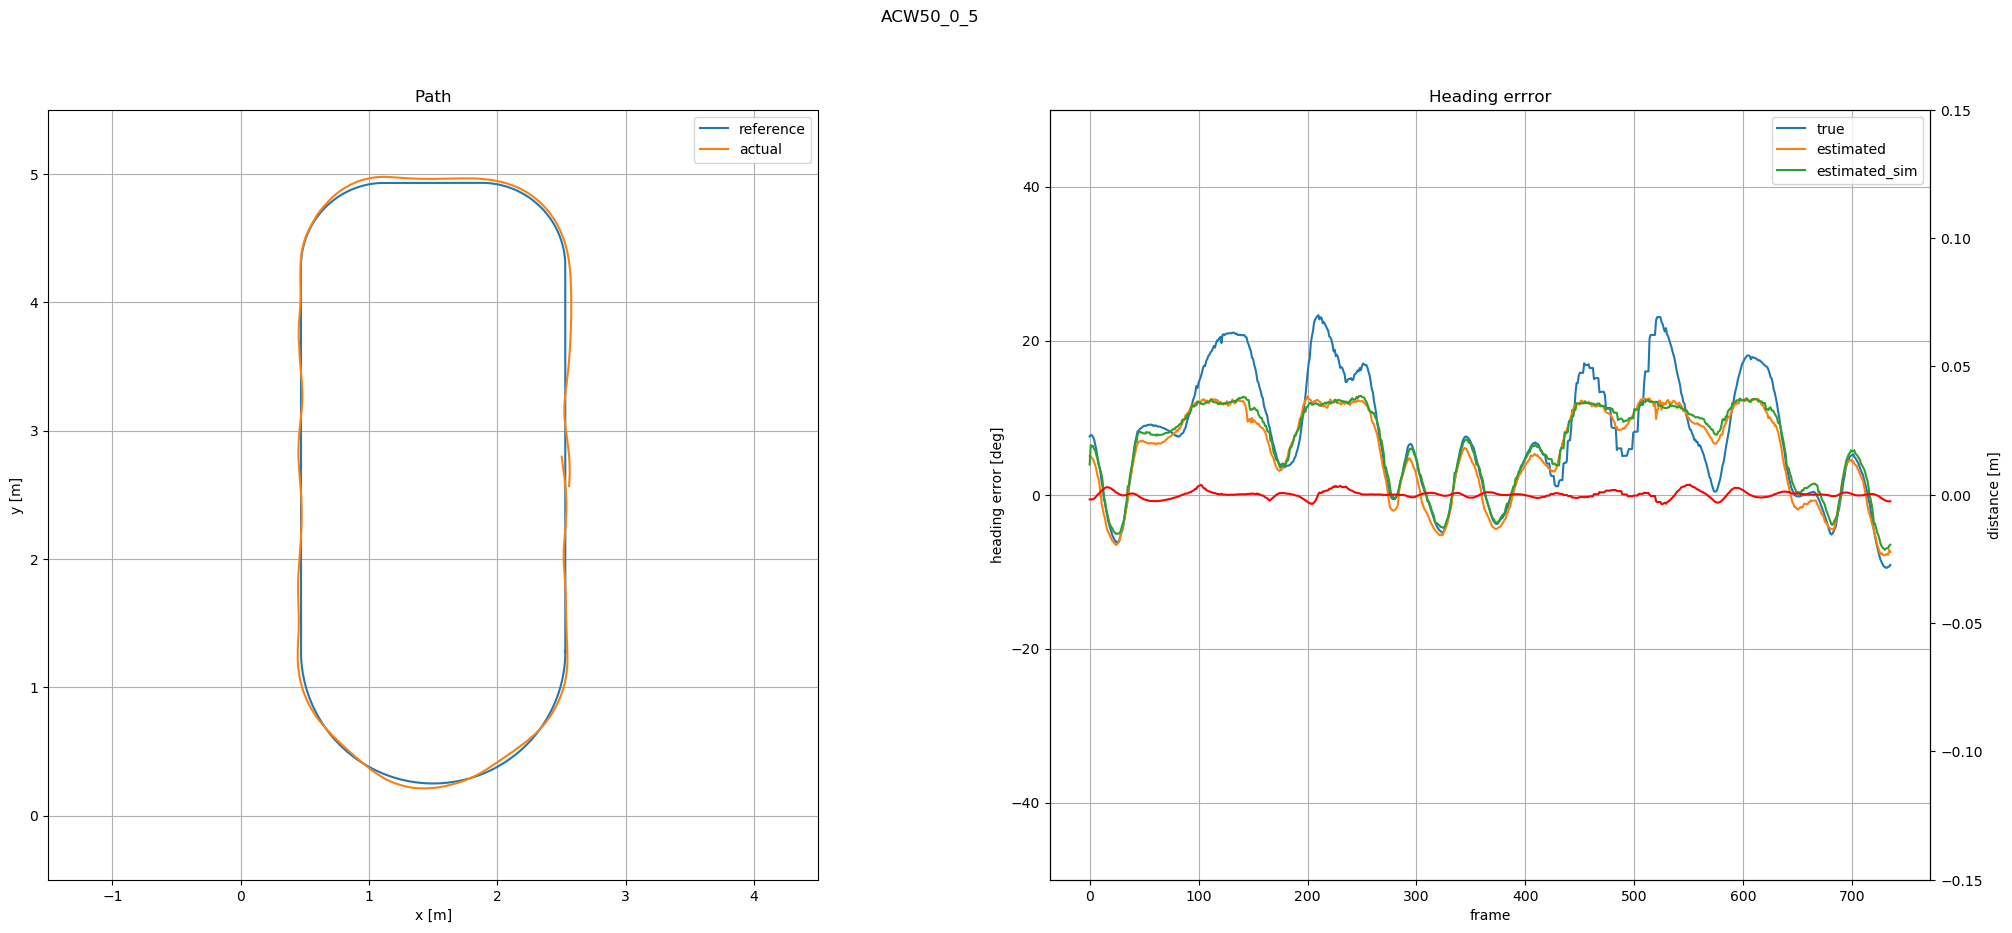

 
ACW50_0_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


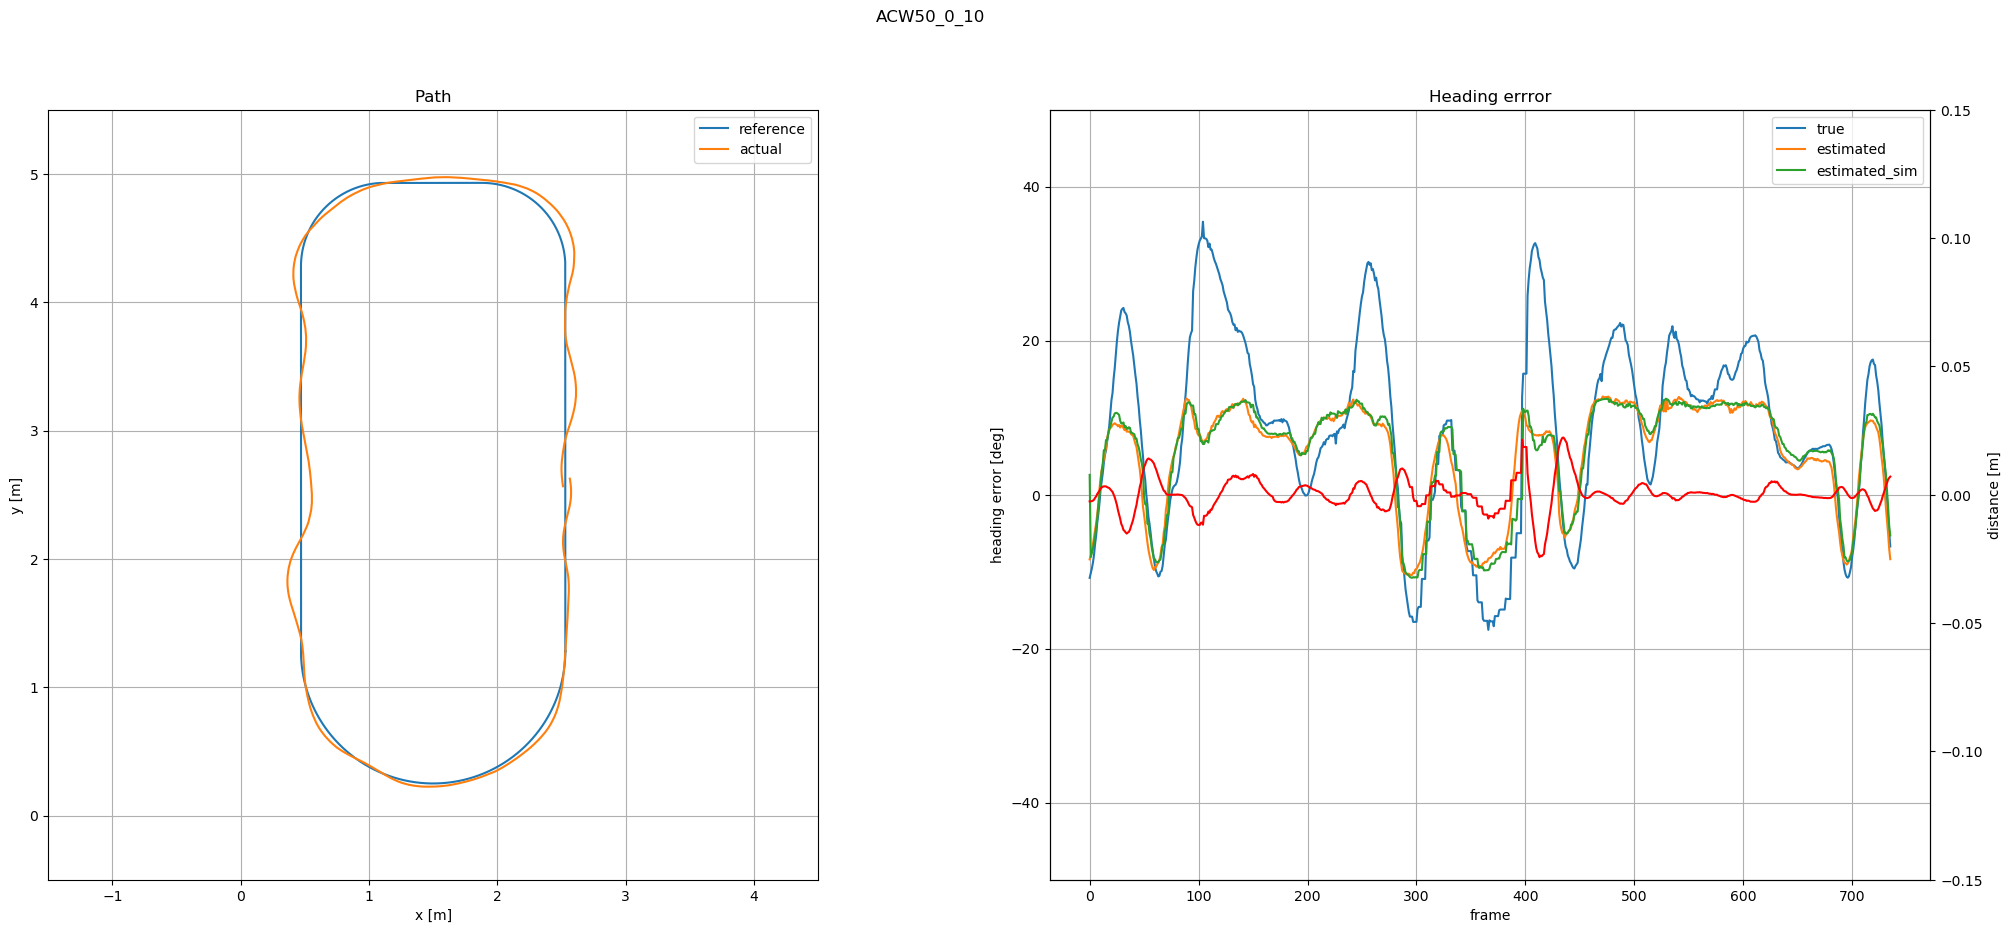

 
ACW50_0_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


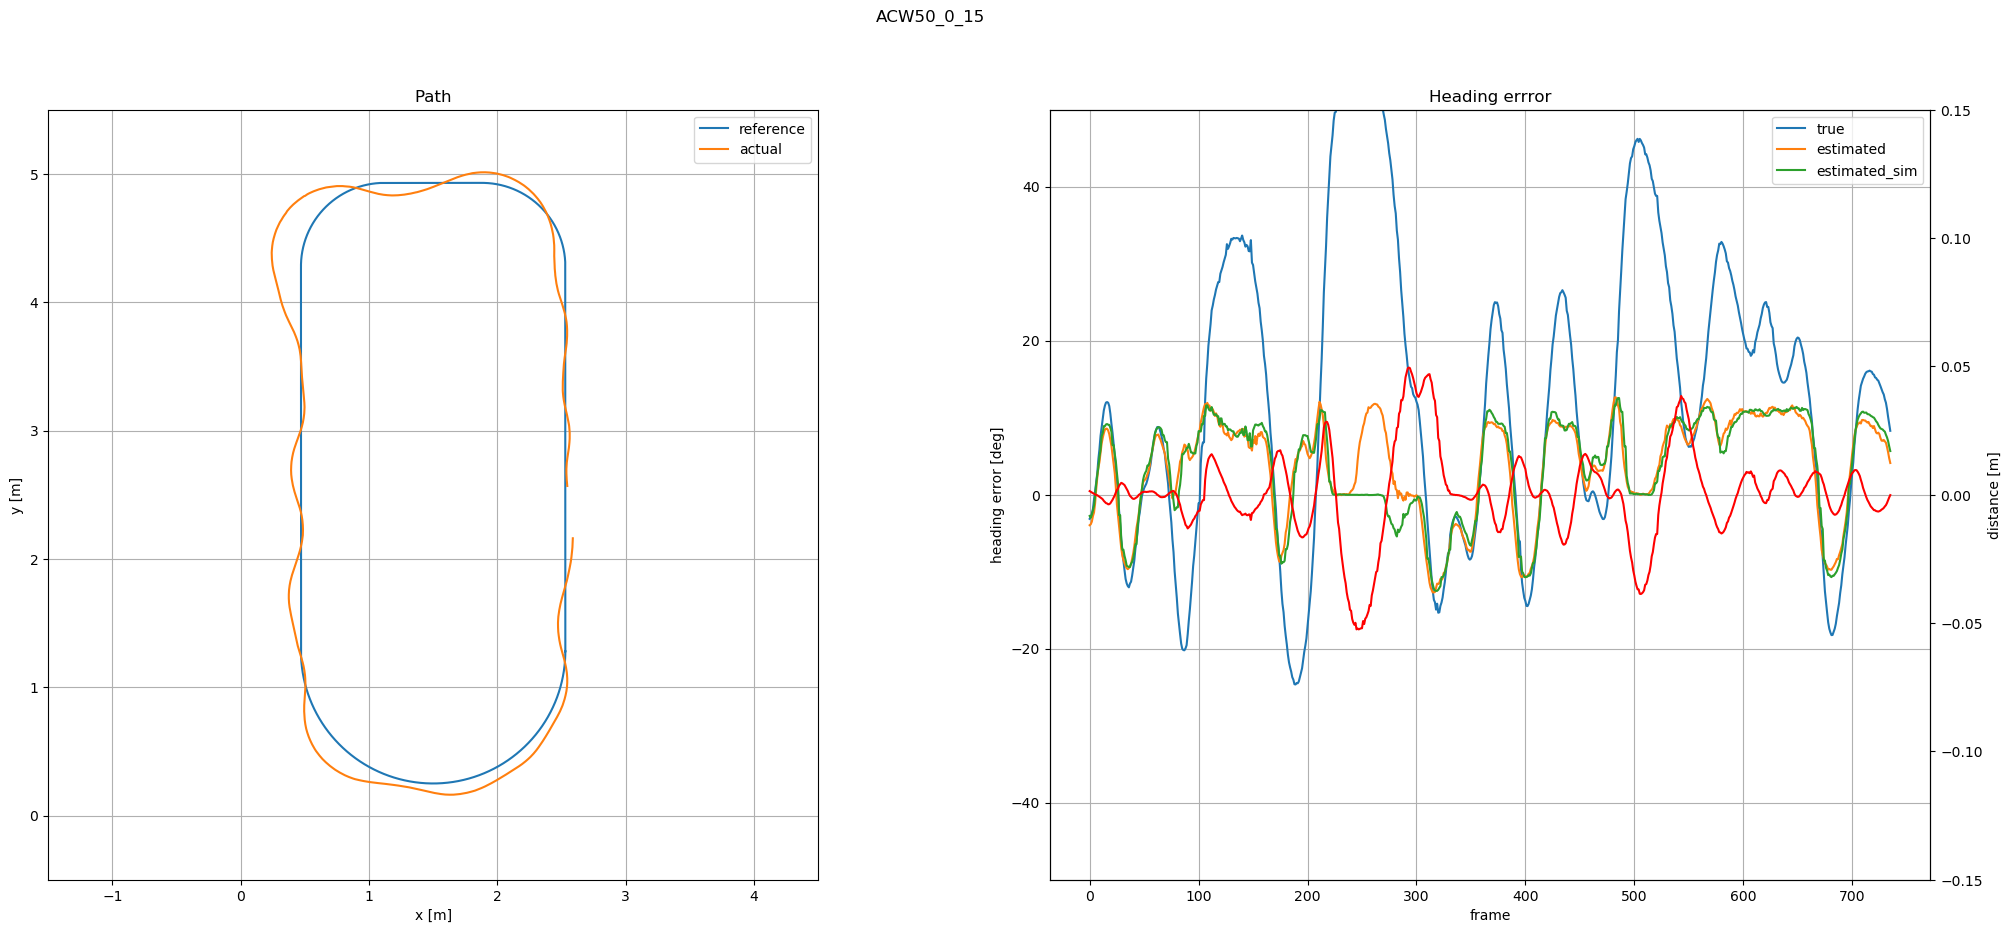

 
ACW50_30_0
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


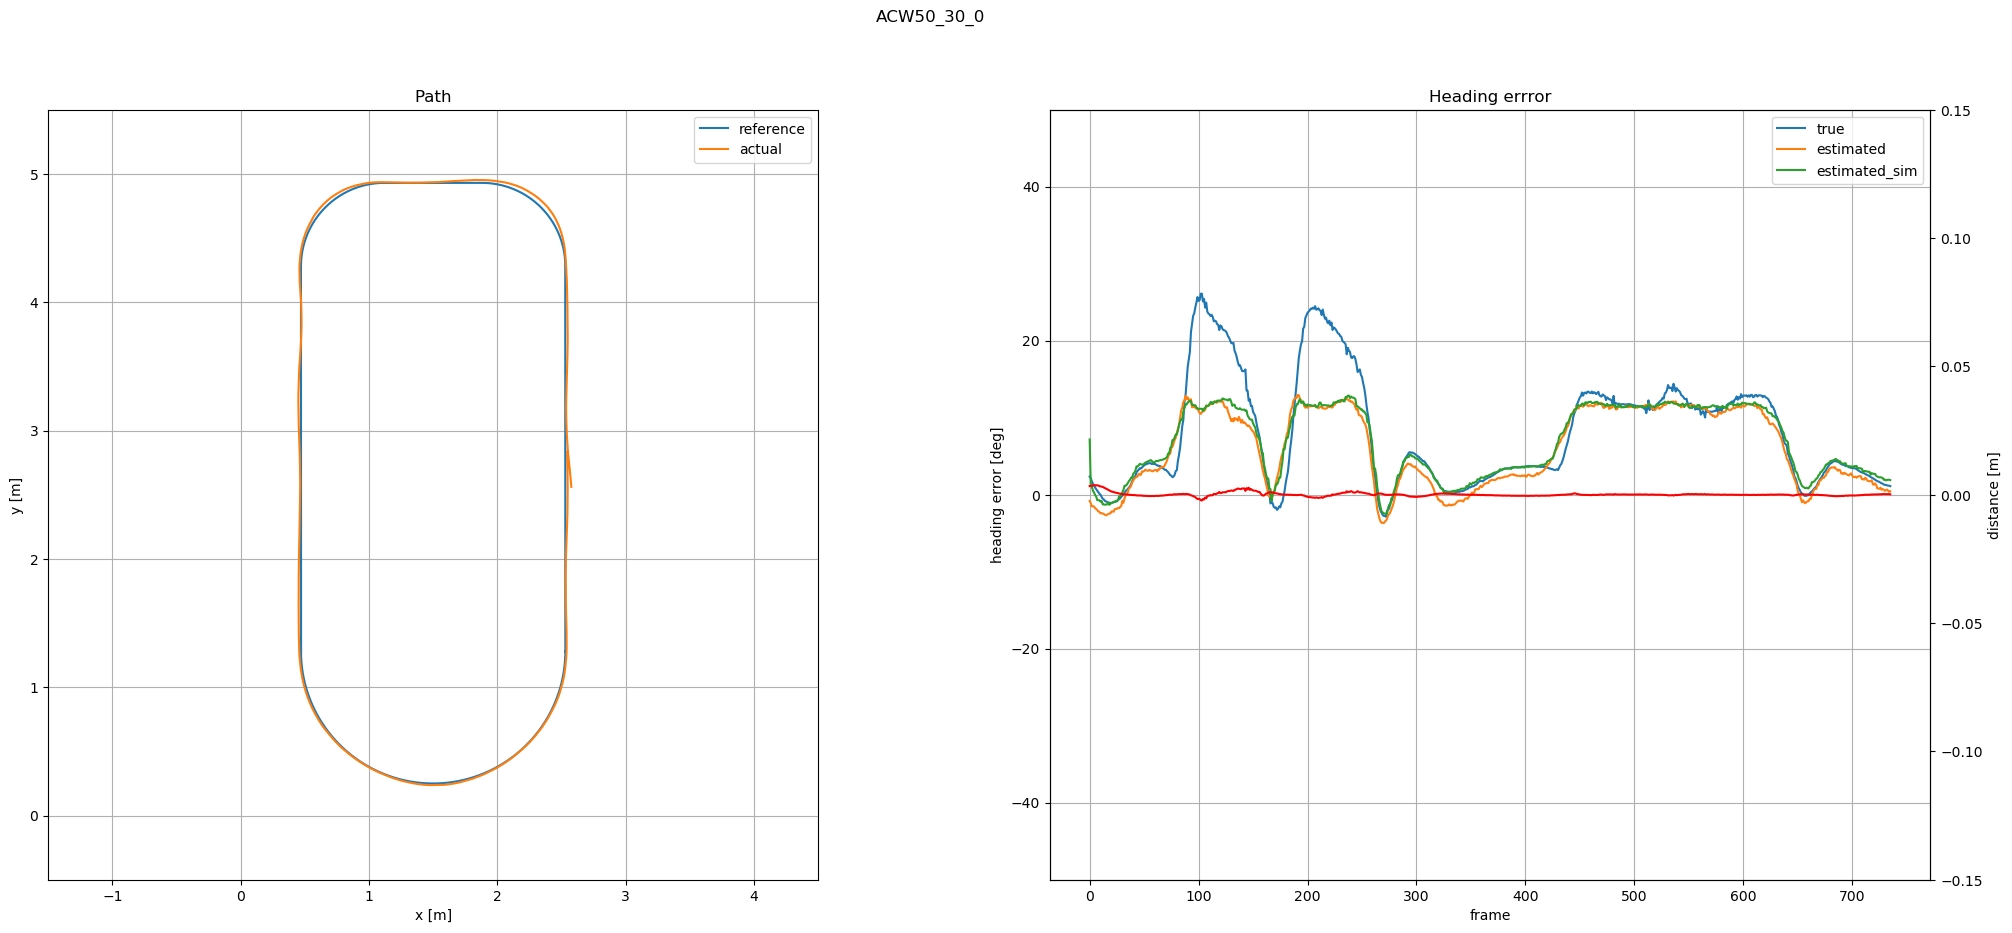

 
ACW50_30_5
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


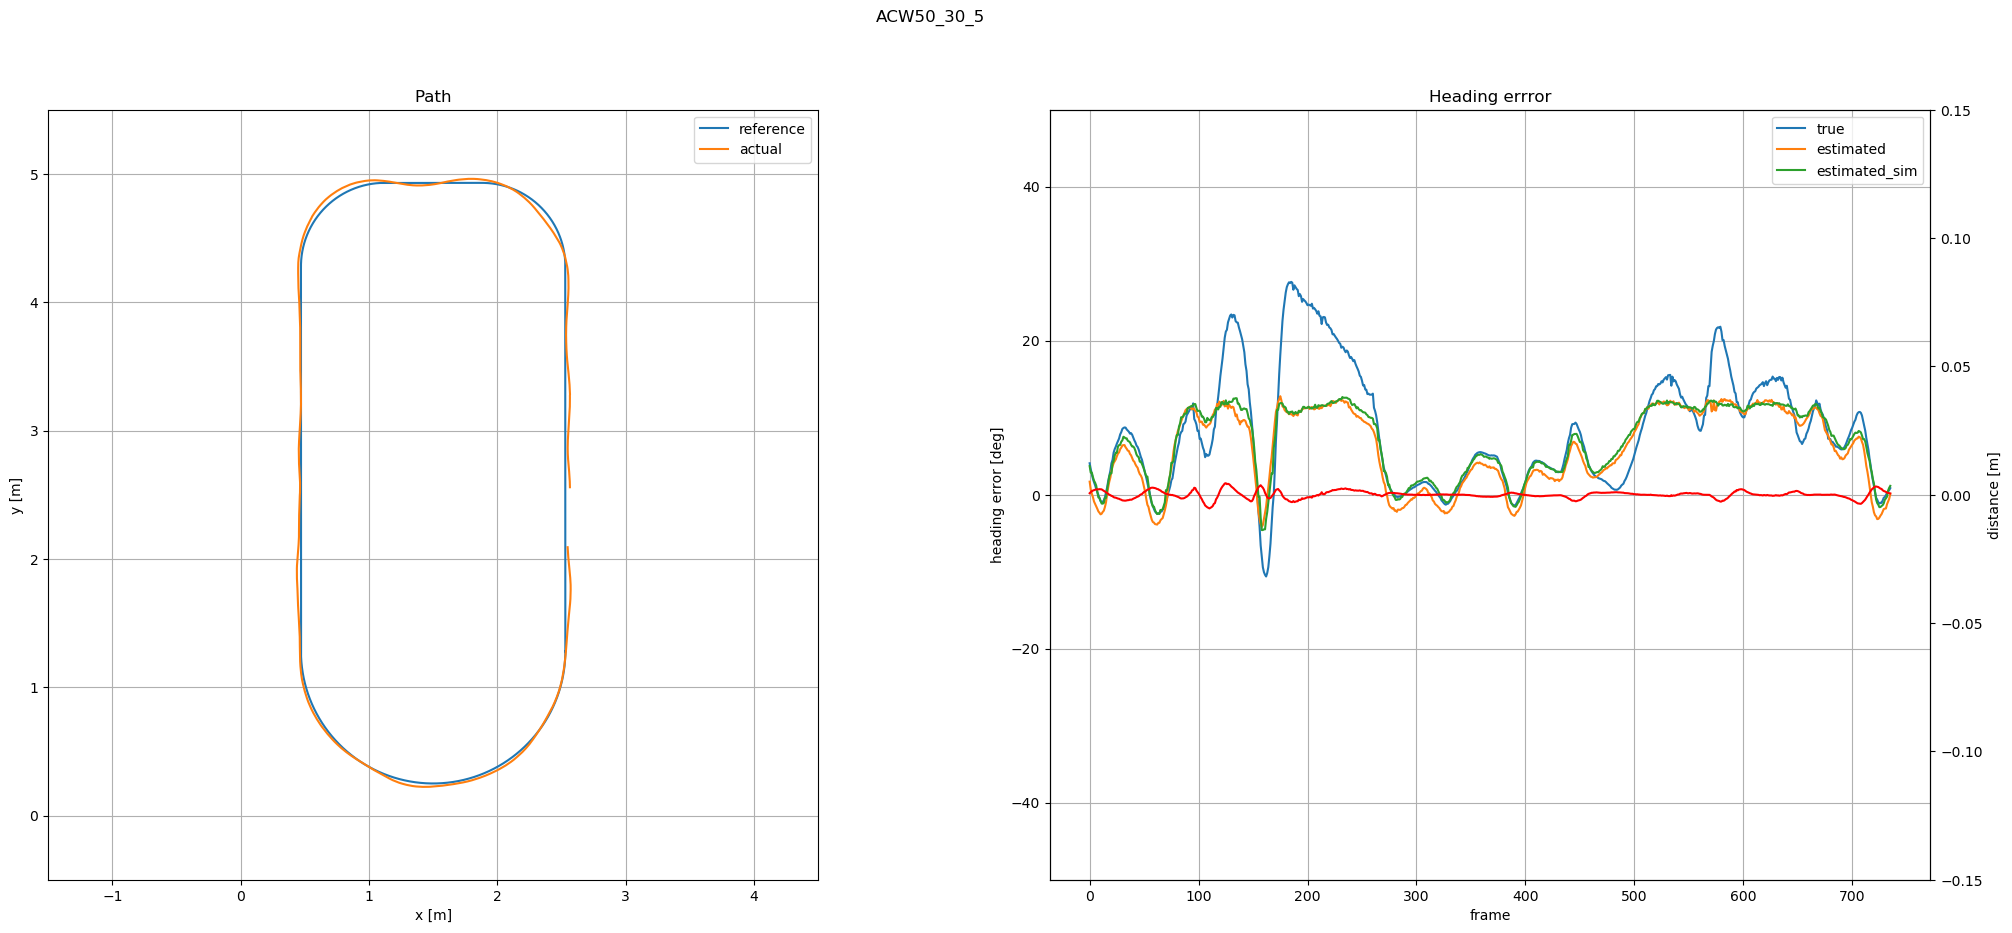

 
ACW50_30_10
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


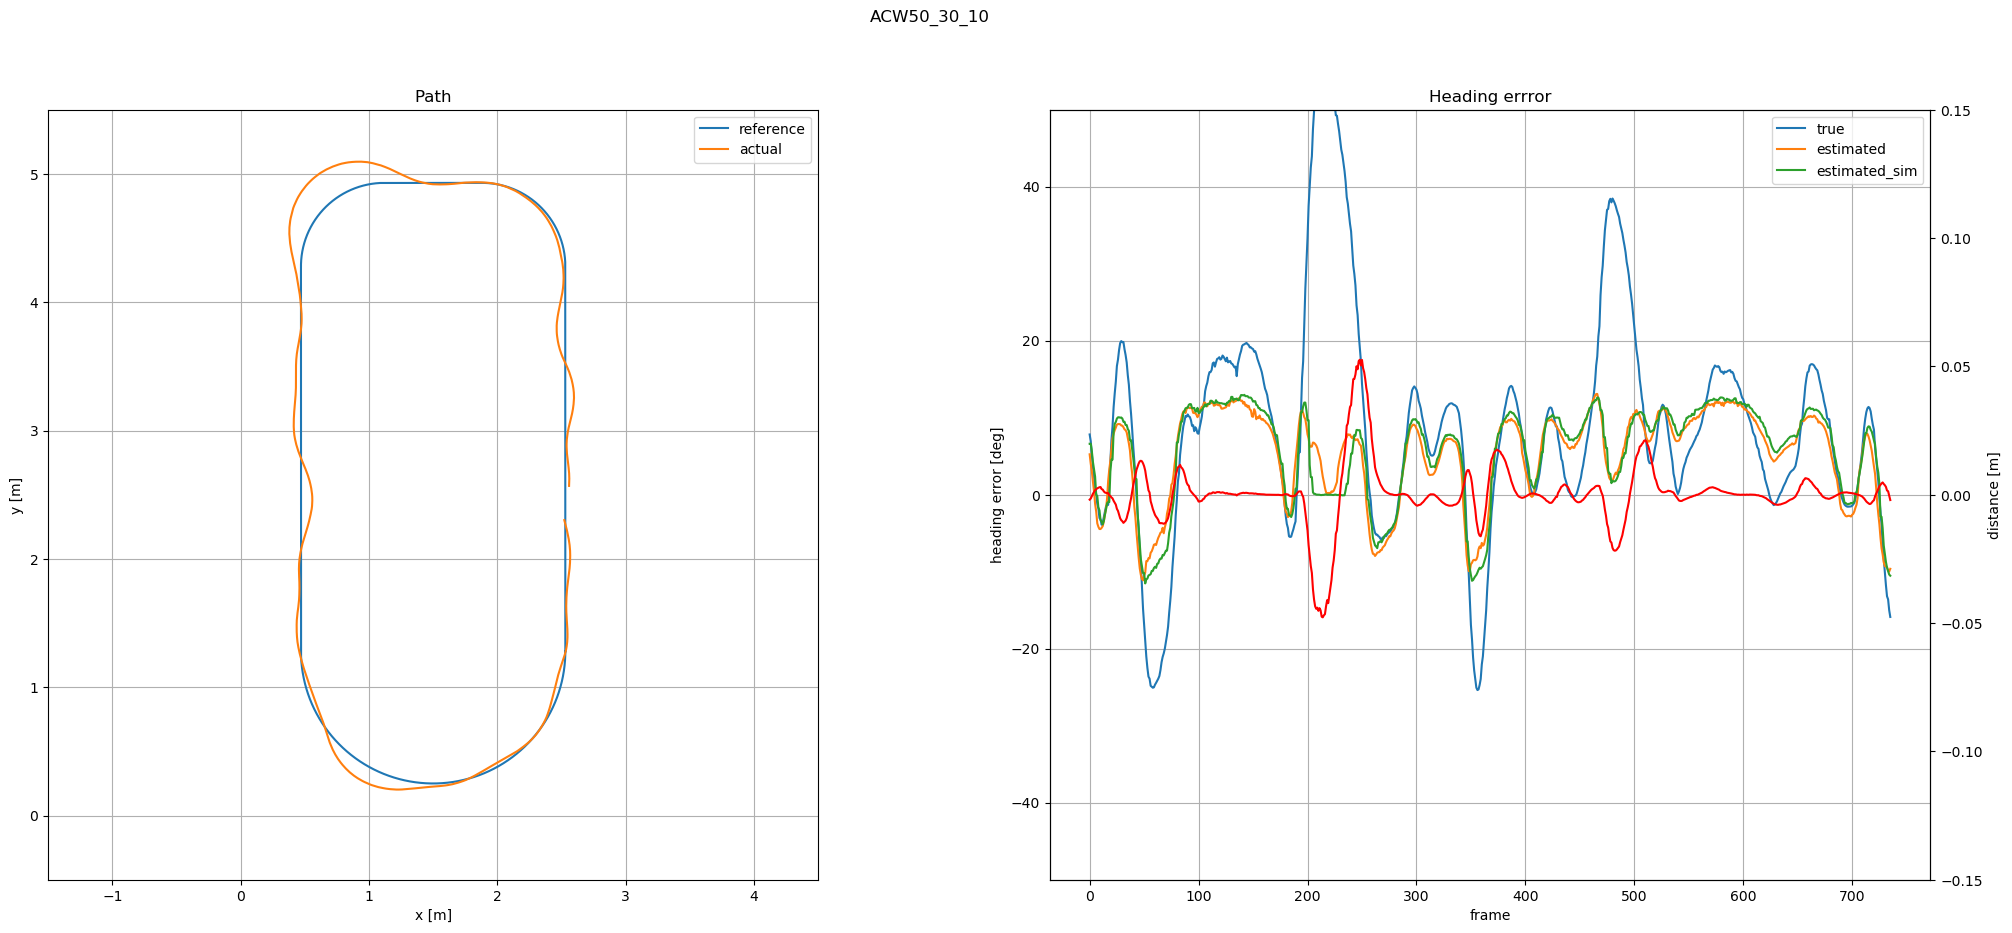

 
ACW50_30_15
frames: 736, locs: 736
frame dim (240, 320), locs dim (3,)


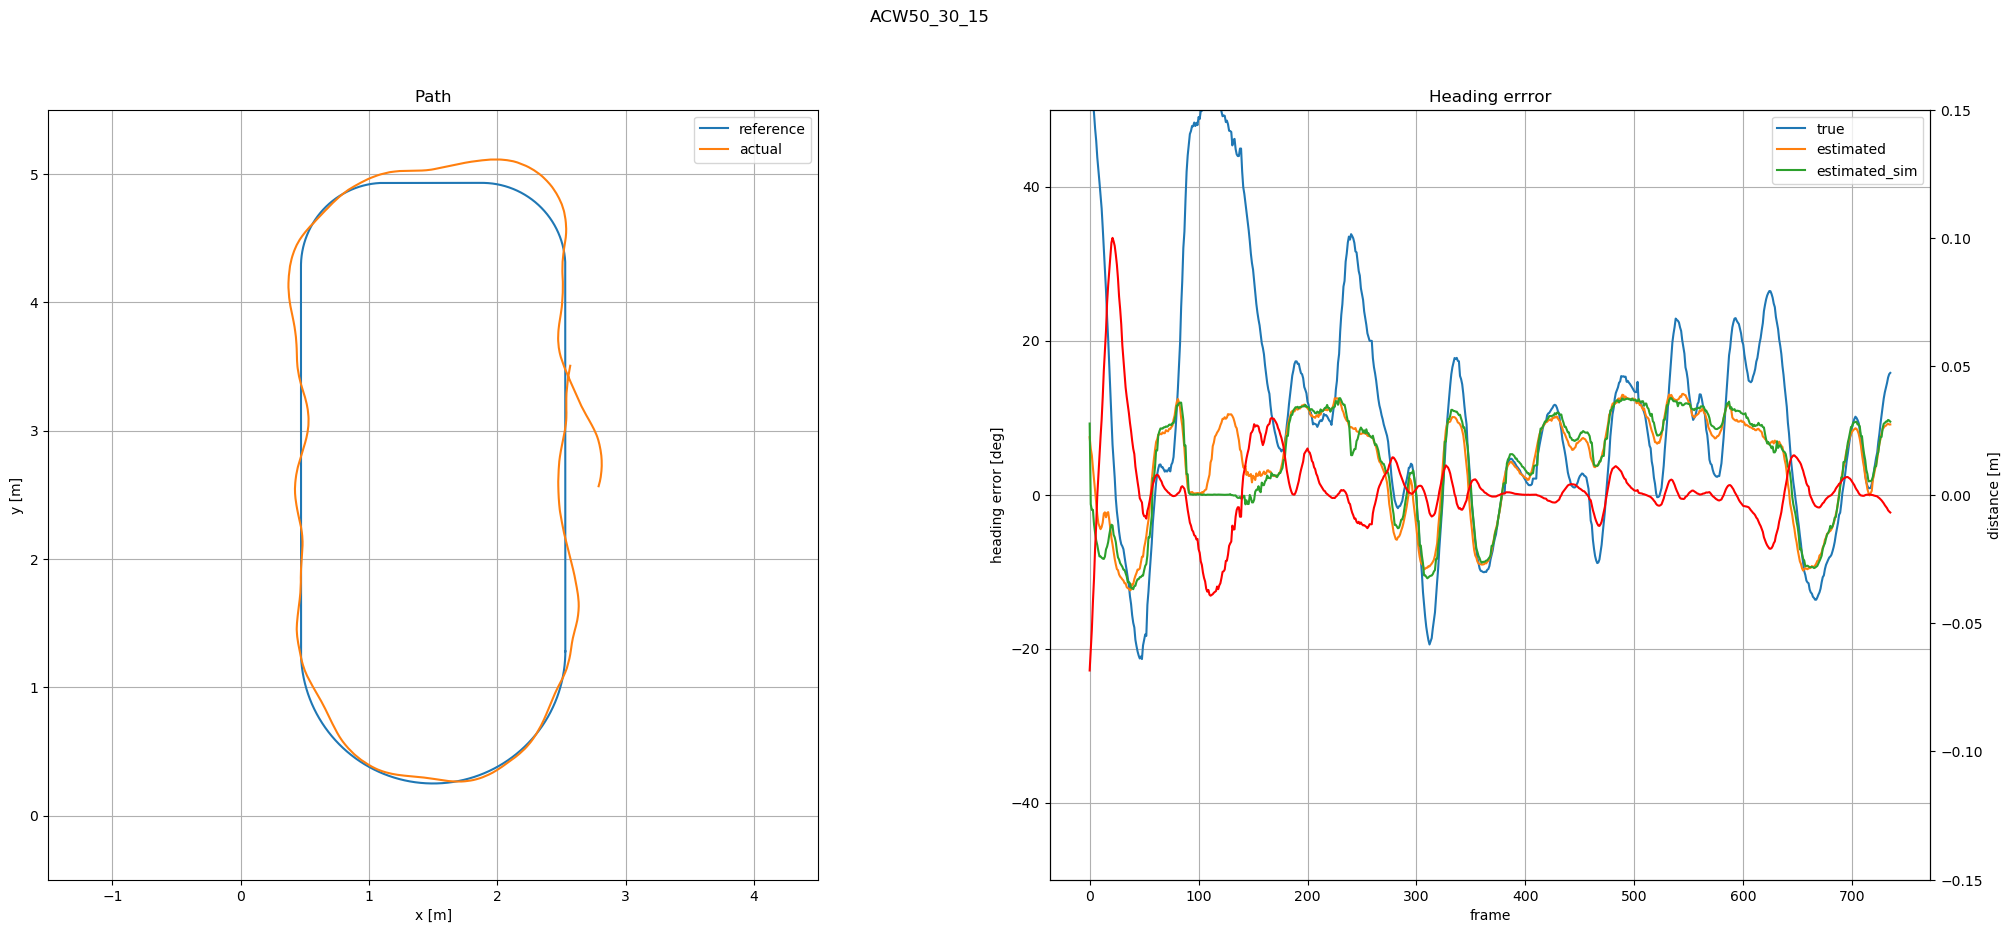

: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from Simulator.src.helper_functions import *
from path_nn_controller import PathPlanning, Controller, Detection
from time import time, sleep
DIST_AHEAD = 0.4

NN = Detection() #initialize neural network

lane_int = np.load('sparcs/sparcs_path_int.npy').T
lane_ext = np.load('sparcs/sparcs_path_ext.npy').T

please_break = False

for name in names:
    print(name)
    log = np.load('saved_tests/'+name+'.npz')
    imgs, locs = log['imgs'],log['locs']
    imgs, locs = compensate_vicon_delay(imgs, locs)
    sim_log = np.load('saved_tests/'+name+'_SIM.npz')
    sim_imgs, sim_locs = sim_log['imgs'],sim_log['locs']
    #get ony the first lap
    imgs = imgs[:1473//2] #//2
    locs = locs[:1473//2] #
    path = np.load('sparcs/sparcs_path_precise.npy').T
    print(f'frames: {len(imgs)}, locs: {len(locs)}')
    print(f'frame dim {imgs[0].shape}, locs dim {locs[0].shape}')

    #check if name starts with CW or ACW
    if name[:3] == 'ACW':
        path = np.flip(path, axis = 0) #if reversed/anti-clockwise

    hes = np.zeros(imgs.shape[0]) #heading error
    est_hes = np.zeros(imgs.shape[0]) #estimated heading error
    est_hes_sim = np.zeros(imgs.shape[0]) #estimated heading error simulator
    dists = np.zeros(imgs.shape[0]) #distances to path

    #calculations over all frames
    for i, (img,sim_img, (x,y,yaw)) in enumerate(zip(imgs,sim_imgs, locs)):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        sim_img = cv.cvtColor(sim_img, cv.COLOR_GRAY2BGR)

        he, pa, d = get_heading_error(x,y,yaw,path, DIST_AHEAD)
        # sleep(10)
        est_he, est_pa = NN.estimate_he(img, distance_point_ahead=DIST_AHEAD, show_ROI=False)
        est_he_sim, est_pa_sim = NN.estimate_he(sim_img, distance_point_ahead=DIST_AHEAD, show_ROI=False)
        hes[i] = np.rad2deg(he)
        est_hes[i] = np.rad2deg(est_he)
        est_hes_sim[i] = np.rad2deg(est_he_sim)
        dists[i] = d

    ###############################################################
    # plotting, showing results

    #create matplotlib figure with 2 subplots
    fig, ax = plt.subplots(1,2, figsize=(25,10))
    fig.suptitle(name)
    ax[0].set_title('Path')
    ax[1].set_title('Heading errror')

    #plot path
    ax[0].plot(path[:,0], path[:,1], label='reference')
    ax[0].plot(locs[:,0], locs[:,1], label='actual')
    ax[0].set_aspect('equal')
    ax[0].legend()
    ax[0].set_xlabel('x [m]')
    ax[0].set_ylabel('y [m]')
    ax[0].set_xlim([1.5-3,1.5+3])
    ax[0].set_ylim([-.5,5.5])
    ax[0].grid()

    #plot heading errors
    ax[1].plot(hes, label='true')
    ax[1].plot(est_hes, label='estimated')
    ax[1].plot(est_hes_sim, label='estimated_sim')
    ax[1].legend()
    ax[1].set_xlabel('frame')
    ax[1].set_ylabel('heading error [deg]')
    ax[1].set_ylim([-50,50])
    ax[1].grid()
    #create twinx
    ax2 = ax[1].twinx()
    ax2.plot(dists, '-r', label='dist ref path')
    # ax2.legend()
    ax2.set_ylabel('distance [m]')
    ax2.set_ylim([-0.15,0.15])
    plt.show(block=False)

    #show images
    cv.namedWindow(name, cv.WINDOW_NORMAL)
    cv.resizeWindow(name, 640, 480)
    cv.namedWindow(name+'_SIM', cv.WINDOW_NORMAL)
    cv.resizeWindow(name+'_SIM', 640, 480)
    for img,sim_img, he, est_he, est_he_sim, (x,y,yaw) in zip(imgs,sim_imgs, hes, est_hes, est_hes_sim, locs):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        sim_img = cv.cvtColor(sim_img, cv.COLOR_GRAY2BGR)   
        
        he = np.deg2rad(he)
        est_he = np.deg2rad(est_he)
        est_he_sim = np.deg2rad(est_he_sim)

        img = draw_angle(img, he, color=(200-50, 200-50, 100-50))
        img = draw_angle(img, est_he, color=(200-50, 100-50, 200-50))
        sim_img = draw_angle(sim_img, he, color=(200-50, 200-50, 100-50))
        sim_img = draw_angle(sim_img, est_he_sim, color=(200-50, 100-50, 200-50))

        #decimate path
        points = np.array([path[::100,0], path[::100,1]]).T
        img, _ = project_onto_frame2(img,points, x,y,yaw, color=(0,0,255), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        img, _ = project_onto_frame2(img,lane_int, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        img, _ = project_onto_frame2(img,lane_ext, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        sim_img, _ = project_onto_frame2(sim_img,points, x,y,yaw, color=(0,0,255), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        sim_img, _ = project_onto_frame2(sim_img,lane_int, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)
        sim_img, _ = project_onto_frame2(sim_img,lane_ext, x,y,yaw, color=(200,200,200), thickness=1, CAM_Z=0.2, CAM_FOV=1.085594795, CAM_PITCH=CAM_PITCH, CAM_ROLL=CAM_ROLL)



        cv.imshow(name, img)
        cv.imshow(name+'_SIM', sim_img)
        please_break = cv.waitKey(1) == 27
        if please_break:
            break
        # sleep(1/160.0)
    if please_break:
        break
    cv.destroyAllWindows()
    print(' ')

cv.destroyAllWindows()

